In [18]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import learning_curve, GridSearchCV

from utils import plot_contour

In [19]:
df_train = pd.read_csv("./data/data_oneleak_train(stratify)_without_outliers.csv")
df_test = pd.read_csv("./data/data_oneleak_test(stratify)_without_outliers.csv")

points_fill = np.array(np.loadtxt("./data/fill.csv"))
points_contour = np.array(np.loadtxt("./data/contour.csv"))

In [20]:
x_train, x_test, y_train, y_test = df_train[["y1","y2"]], df_test[["y1","y2"]], np.array(tf.argmax(df_train.iloc[:,:10].values, axis=1)) + 1, np.array(tf.argmax(df_test.iloc[:,:10].values, axis=1)) + 1

In [21]:
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
)

In [22]:
# Define the parameters for grid search
param_grid = {
    'knn__n_neighbors': range(1, 21),  # Search for k from 1 to 20
}

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 21)})

In [23]:
# Set the best parameters obtained from grid search
best_k = grid_search.best_params_['knn__n_neighbors']
weights = "distance"

start = time.time()

# Define the pipeline with the best parameters
clf.set_params(knn__n_neighbors=best_k, knn__weights=weights)

# Fit the pipeline with the best parameters to the training data
clf.fit(x_train, y_train)

end = time.time()

print(f"Best k: {best_k}")

Best k: 9


In [24]:
start = time.time()
weights = "distance"

fig = plt.figure(figsize=(40, 10))
clf.set_params(knn__weights=weights).fit(x_train, y_train)
end = time.time()

<Figure size 4000x1000 with 0 Axes>

In [25]:
y_pred = clf.predict(x_test)

In [26]:
def accuracy(y_pred,y_true):
    return np.sum(y_pred==y_true)*100/len(y_pred)

In [27]:
train_acc = accuracy(y_pred=clf.predict(x_train),y_true=y_train)
print(f"The training accuracy for k nearest neighbours is {train_acc}")

The training accuracy for k nearest neighbours is 100.0


In [28]:
acc = accuracy(y_pred=y_pred,y_true=y_test)
print(f"The accuracy for k nearest neighbours is {acc}")

The accuracy for k nearest neighbours is 90.19607843137256


In [29]:
print(f"Time required to fit the model: {end-start} seconds.")

Time required to fit the model: 0.004275321960449219 seconds.


### Visualisation for training data

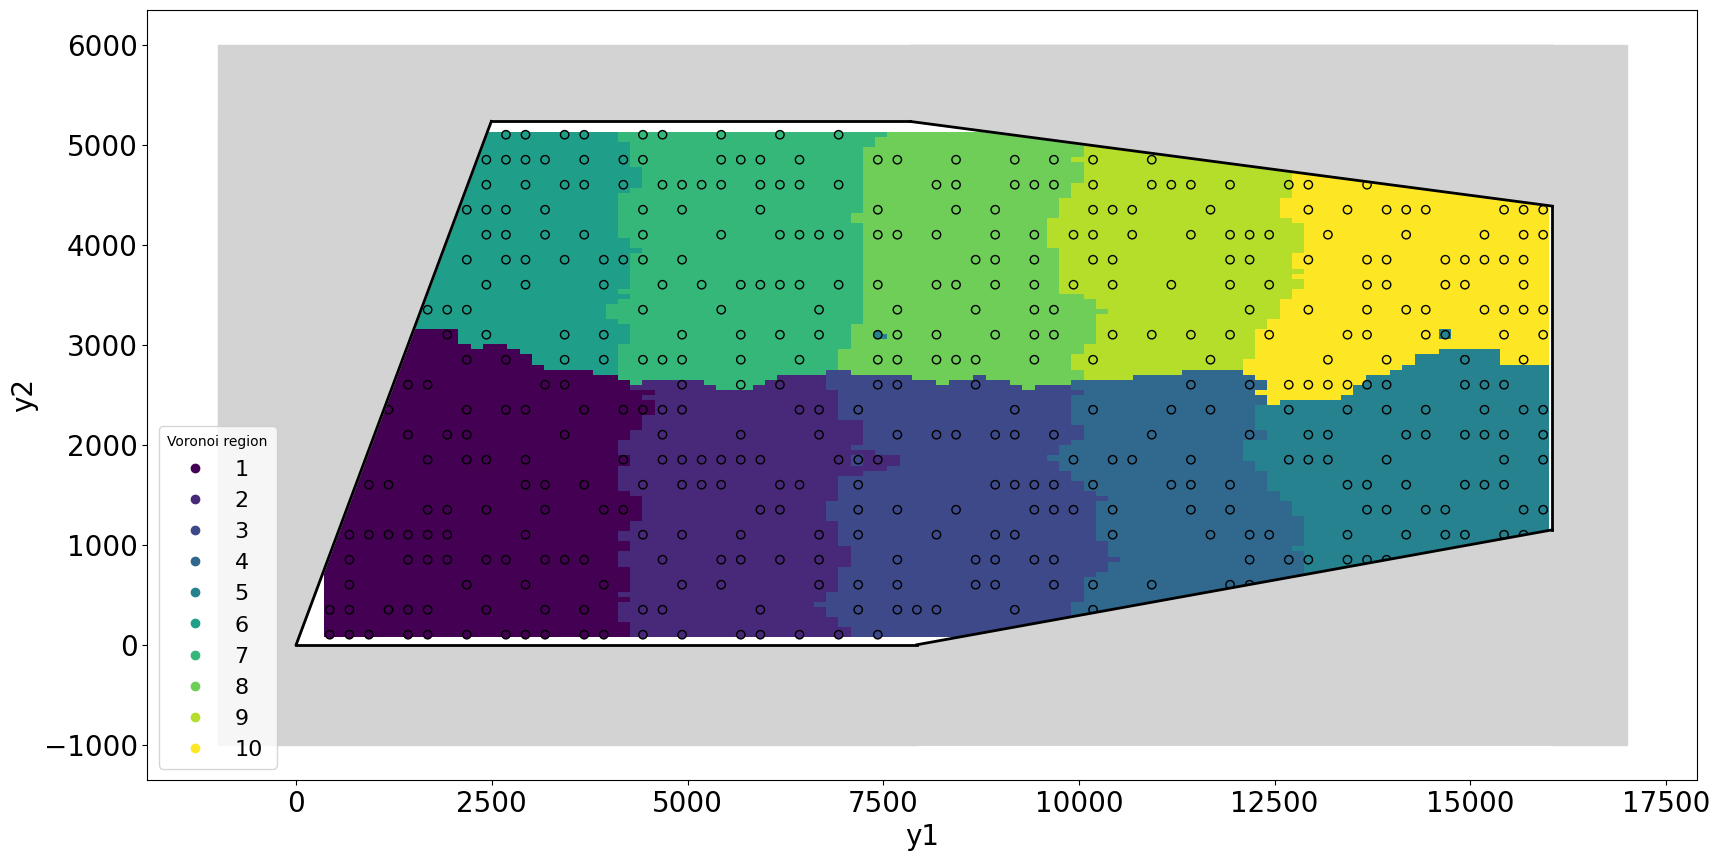

In [30]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   

plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, edgecolors="k")

disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_train)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"10-Class classification for Training data - with outliers\n(k={clf[-1].n_neighbors}, weights=distance)\ndata_oneleak_train(stratify)_with_outliers.csv"
# )

plt.show()


In [15]:
fig.savefig(f"./plots/Final/Stratify/Without outliers/K-NN_without_training.png")

### Visualisation for testing data

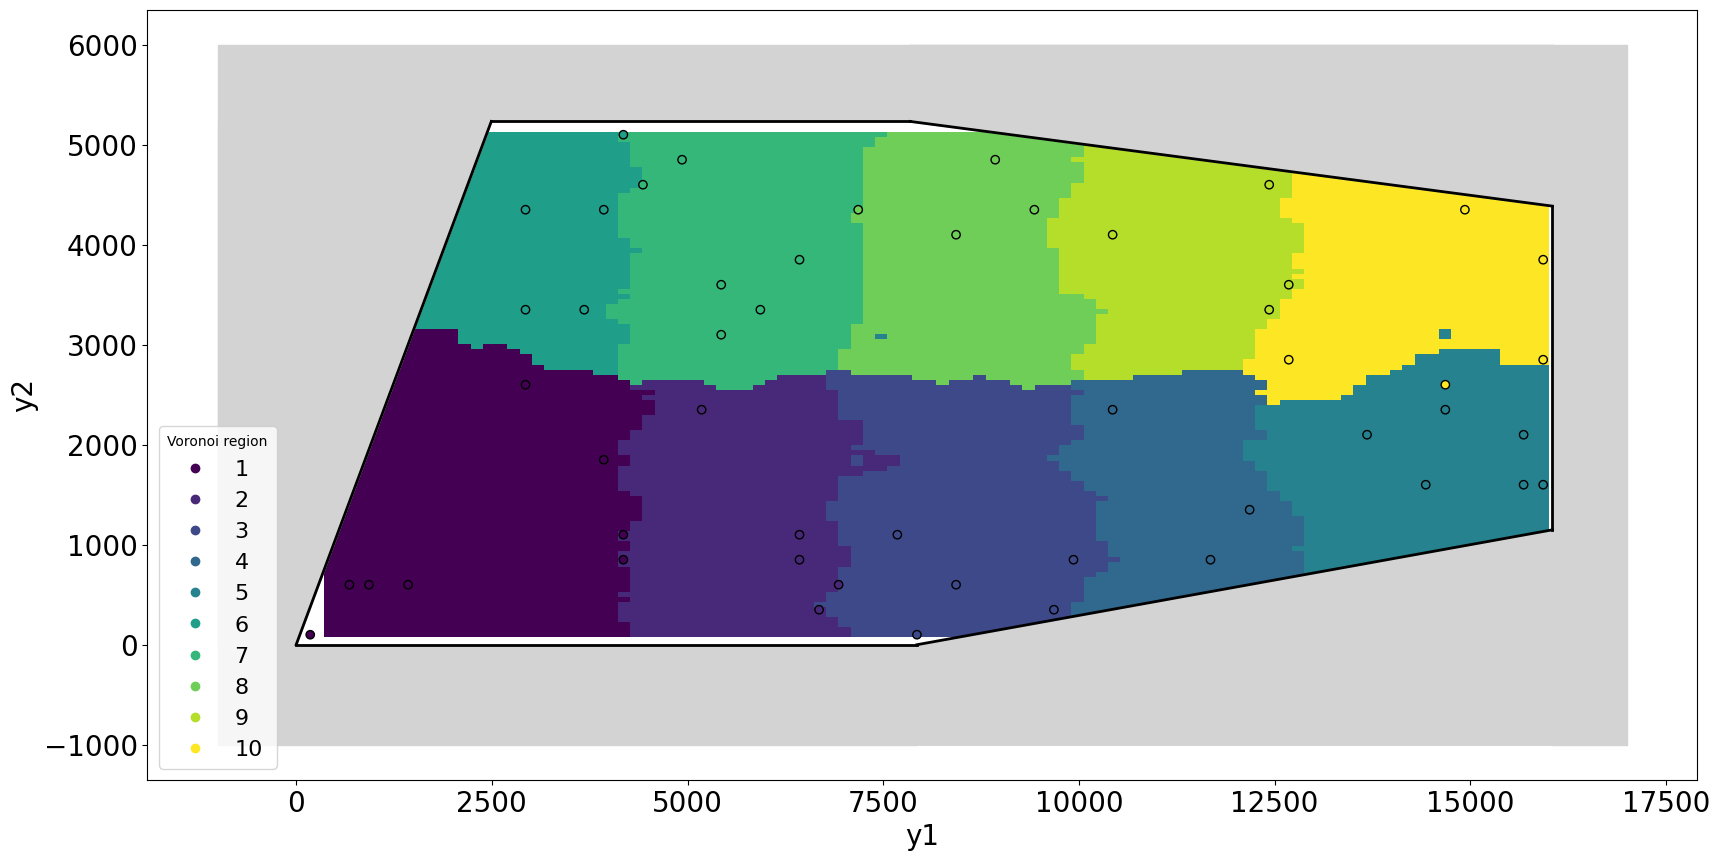

In [31]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 10))

#plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   

plot_contour(points_contour,points_fill)

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="y1",
    ylabel="y2",
    shading="auto",
    ax=axs
)
scatter = disp.ax_.scatter(x_test.iloc[:, 0], x_test.iloc[:, 1], c=y_test, edgecolors="k")

disp.ax_.legend(
    scatter.legend_elements()[0],
    list(set(y_test)),
    loc="lower left",
    title="Voronoi region",
)
# _ = disp.ax_.set_title(
#     f"10-Class classification for Testing data - with outliers\n(k={clf[-1].n_neighbors}, weights=distance, accuracy={acc})\ndata_oneleak_test(stratify)_with_outliers.csv"
# )

plt.show()


In [17]:
fig.savefig(f"./plots/Final/Stratify/With outliers/K-NN_with_testing.png")

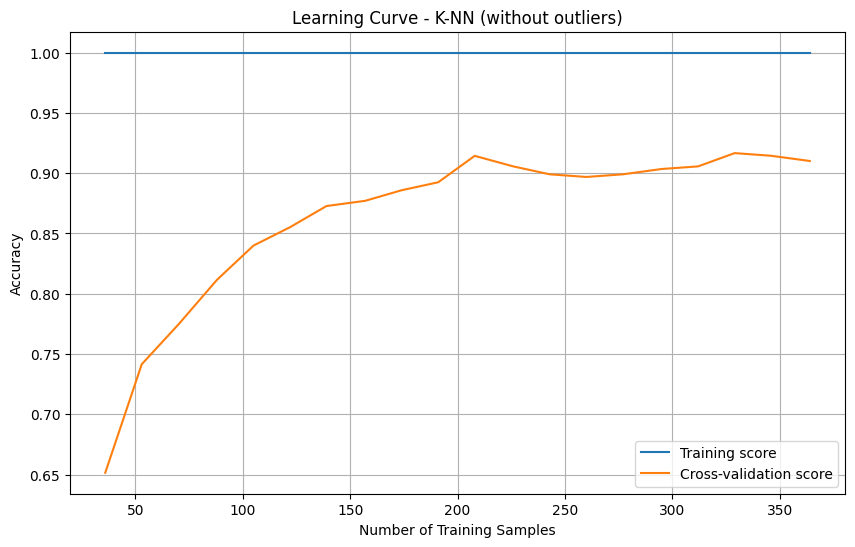

In [46]:
train_sizes, train_scores, valid_scores = learning_curve(clf, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 20), cv=5)

fig = plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curve - K-NN (without outliers)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
fig.savefig("./plots/Final/Stratify/Without outliers/Learning curve - K-NN.png")